# Segmenting nerves

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# import the volume
im = io.imread('nerves_part.tiff').astype(np.float32)
print(im.shape)

(1024, 350, 350)


In [2]:
%run helper_functions.py

All helper functions loaded.


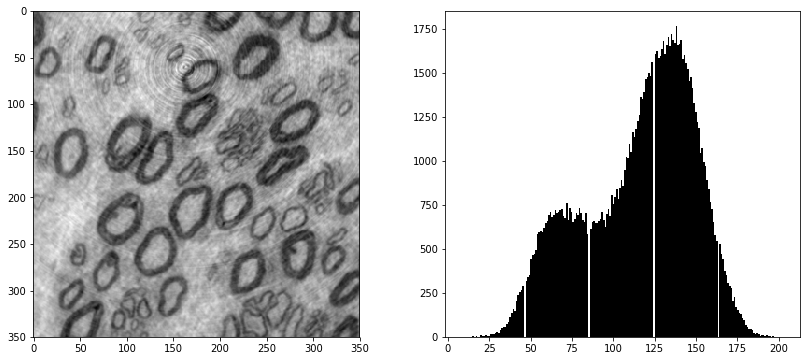

In [3]:
# let's start by looking at a single image
img = im[0]

# invert and scale to values between 0.0 and 1.0
from skimage.util import invert
inv = invert(img/255)

f, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].imshow(img, cmap='gray'); # inverted
ax[1].hist(img.ravel(), bins=200, color='k');

## Thresholding and Markov Random Field

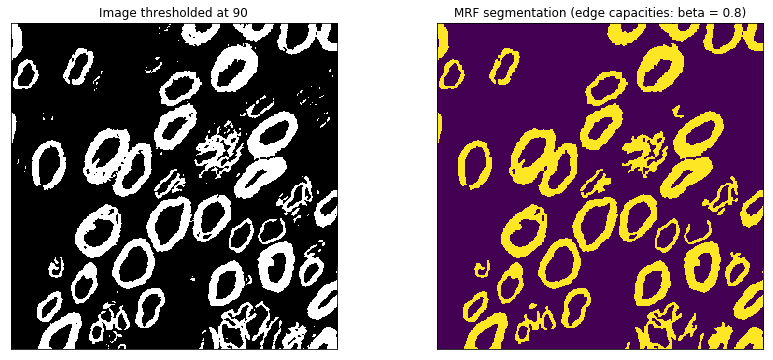

In [4]:
import scipy
import maxflow

# thresholding based on histogram
img_th = img<90

# Create the graph.
g = maxflow.Graph[float]()

# make each pixel of the image a (consecutively labeled) node
nodes = g.add_grid_nodes(inv.shape)

# Non-terminal edges have the same capacity as the nodes
g.add_grid_edges(nodes, 0.8) # beta = 0.8 seems to work well on this
g.add_grid_tedges(nodes, img_th, 1.2-img_th) # terminal edges

# Compute max. flow through the constructed graph
g.maxflow()
    
# Get the segments of the nodes in the grid.
# Their labels are 1 where sgm is False and 0 otherwise.
sgm = g.get_grid_segments(nodes)
# save the segmented image    
binaryimg = np.int_(np.logical_not(sgm))


f, ax = plt.subplots(figsize = (14,6), ncols=2)
ax[0].imshow(img_th, cmap='gray');
ax[0].set(title='Image thresholded at 90', xticks=[], yticks=[])
ax[1].imshow(binaryimg);
ax[1].set(title=('MRF segmentation (edge capacities: beta = 0.8)'),
                            xticks=[], yticks=[]);

### Fitting a deformable model to a well separated nerve cell
Let's first look at a small fraction of the image. We'll initialize a circular snake at the center of the nerve and iteratively update its shape by consecutively calling `updateCurve` (see *helper_functions.py*) on it.

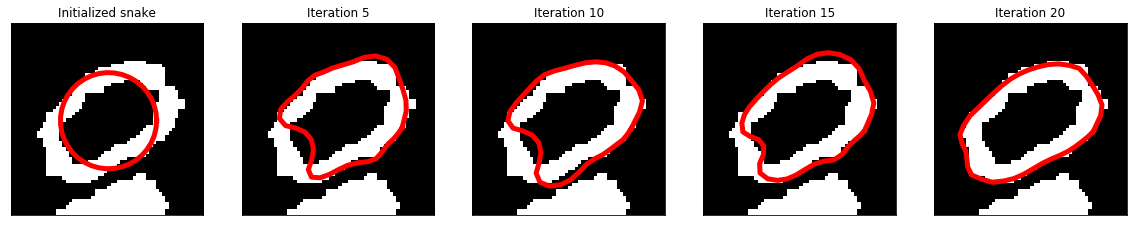

In [5]:
testnerve = binaryimg[40:100, 150:210]
h,w = testnerve.shape
snakepoints = 40

Snake = InitSnake((h/2,w/2), h/4, snakepoints)

B = SmoothKernel(Snake, 0.9, 0.7)

Snake_tmp = updateCurve(testnerve, Snake, B)

f, ax = plt.subplots(ncols=5, figsize=(20,6))

for i in range(21):
    
    Snake_tmp = updateCurve(testnerve, Snake_tmp, B)
    
    if i%5 == 0:
        j = int(i/5)
        if i == 0:
            ax[j].imshow(testnerve, cmap = 'gray')
            ax[j].plot(Snake[0,:], Snake[1,:], color = 'r', linewidth = 5);
            ax[j].set(title='Initialized snake', xticks=[], yticks=[])
        else:
            ax[j].imshow(testnerve, cmap = 'gray');
            ax[j].plot(Snake_tmp[0,:], Snake_tmp[1,:], color = 'r', linewidth = 5);
            ax[j].set(title='Iteration '+str(i), xticks=[], yticks=[])

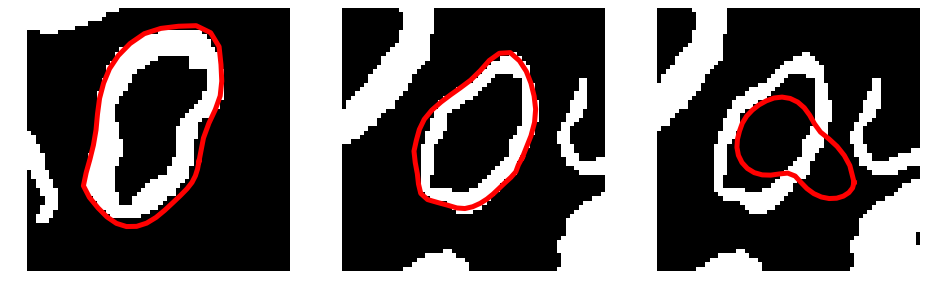

In [6]:
# let's first look at a small fraction of the image
nerve2 = binaryimg[280:340, 120:180]
nerve3 = binaryimg[200:260, 215:275]
nerve4 = binaryimg[200:260, 220:280]

h,w = nerve2.shape


snakepoints = 40
Snake = InitSnake((h/2,w/2), h/4, snakepoints)

B = SmoothKernel(Snake, 0.9, 0.7)

f, ax = plt.subplots(ncols=3, figsize=(16,5))

ax[0].imshow(nerve2, cmap = 'gray');
ax[0].axis("off");

Snake_tmp = updateCurve(nerve2, Snake, B)
# iteratively update the fitted curve:
for i in range(40):
    Snake_tmp = updateCurve(nerve2, Snake_tmp, B)
    
ax[0].plot(Snake_tmp[0,:], Snake_tmp[1,:], color = 'r', linewidth = 5);

ax[1].imshow(nerve3, cmap = 'gray');
ax[1].axis("off");

Snake_tmp3 = updateCurve(nerve3, Snake, B)
# iteratively update the fitted curve:
for j in range(40):
    Snake_tmp3 = updateCurve(nerve3, Snake_tmp3, B)
    
ax[1].plot(Snake_tmp3[0,:], Snake_tmp3[1,:], color = 'r', linewidth = 5);


ax[2].imshow(nerve4, cmap = 'gray');
ax[2].axis("off");

Snake_tmp4 = updateCurve(nerve4, Snake, B)
# iteratively update the fitted curve:
for j in range(40):
    Snake_tmp4 = updateCurve(nerve4, Snake_tmp4, B)
    
ax[2].plot(Snake_tmp4[0,:], Snake_tmp4[1,:], color = 'r', linewidth = 5);

In general, this approach seems to work well for cells that are properly segmented. However, the __initialization of the snake turns out to be cruicial.__ The plot above shows proper convergence in the left and middle image segment. Performance decreases however, if the snake is not initialized in the center of the cell, as shown on the right.

# Next... Blob detection?